# **DATA PREPARATION**

**Feature Selection**

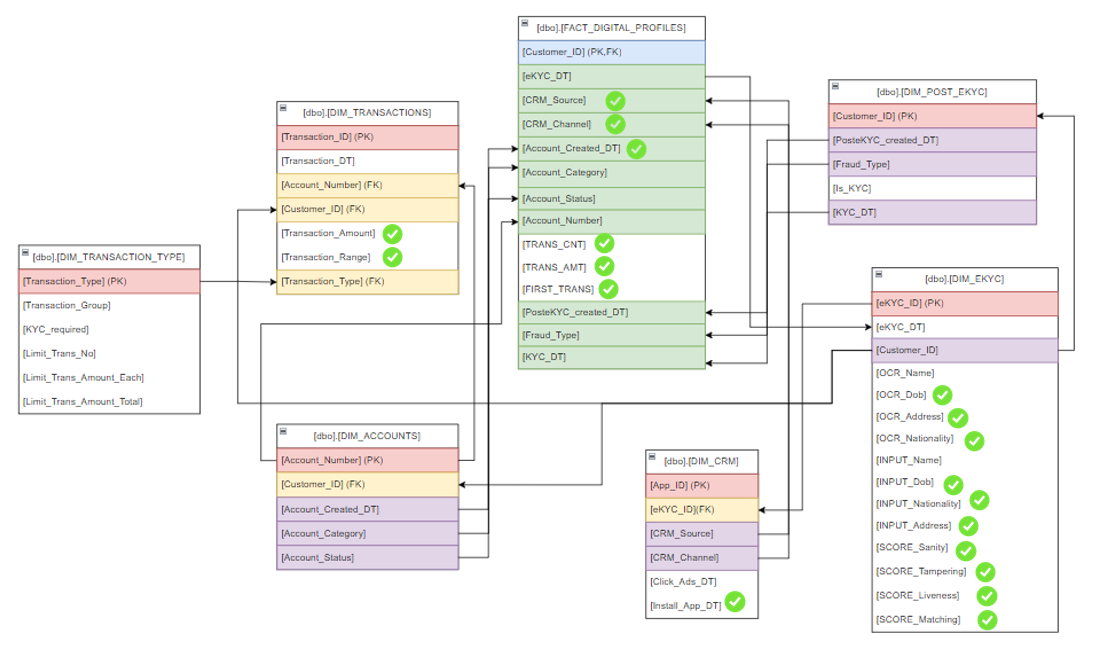

The marked featuers can be used to train the model

In [1]:
'''!pip install pyodbc
!pip install sqlserverport
!sudo apt-get install unixodbc-dev
!pip install pyodbc
!pip install chart_studio'''

'!pip install pyodbc\n!pip install sqlserverport\n!sudo apt-get install unixodbc-dev\n!pip install pyodbc\n!pip install chart_studio'

In [2]:
'''BaseExceptionGroup%%sh
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add /etc/apt/trusted.gpg
curl https://packages.microsoft.com/config/ubuntu/18.04/prod.list > /etc/apt/sources.list.d/mssql-release.list
sudo apt-get update
sudo apt install --fix-broken
sudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17'''

'BaseExceptionGroup%%sh\ncurl https://packages.microsoft.com/keys/microsoft.asc | apt-key add /etc/apt/trusted.gpg\ncurl https://packages.microsoft.com/config/ubuntu/18.04/prod.list > /etc/apt/sources.list.d/mssql-release.list\nsudo apt-get update\nsudo apt install --fix-broken\nsudo ACCEPT_EULA=Y apt-get -q -y install msodbcsql17'

In [3]:
import pyodbc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Import all the learning algorithms we want to test
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier



#Import some utilities of sklearn to compare algorithms
from sklearn.model_selection import cross_val_predict,train_test_split,cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn import linear_model,model_selection
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,roc_curve,confusion_matrix

### **Loading Dataset**

In [4]:
conn = pyodbc.connect(driver='ODBC Driver 17 for SQL Server', server='DESKTOP-MT8URLR\BAOAN', database='DWH', Trusted_Connection='yes',port=1433)

#### Get Dataframe

In [5]:
query_scripts = """
WITH N AS
(
	SELECT F.[CRM_Channel]
		  ,F.[Customer_ID]
		  ,C.[Install_App_DT]
		  ,F.[eKYC_DT]
		  ,[Account_Created_DT]
		  ,[FIRST_TRANS]
		  ,[TRANS_CNT]
		  ,IIF(T.[Transaction_Range] = 'LOW', '1 - LOW'
				,IIF(T.[Transaction_Range] = 'MEDIUM LOW','2 - MEDIUM LOW'
						,IIF(T.[Transaction_Range] = 'MEDIUM HIGH','3 - MEDIUM HIGH'
							,IIF(T.[Transaction_Range] = 'HIGH','4 - HIGH', '0 - NO TRANS')))) [First_Transaction_Range]
		  ,E.[OCR_Nationality]
		  ,DATEDIFF(YEAR, E.[OCR_Dob], SYSDATETIME()) [AGE]
		  ,E.[SCORE_Liveness]
		  ,E.[SCORE_Matching]
		  ,E.[SCORE_Sanity]
		  ,E.[SCORE_Tampering]
		  ,[FRAUD_TYPE]
	  FROM [DWH].[dbo].[FACT_DIGITAL_PROFILES] F
	  --LEFT JOIN [DWH].[dbo].[DIM_CRM] C ON C.[App_ID] =  F.[App_ID]
	  LEFT JOIN  [DWH].[dbo].[DIM_EKYC] E ON E.[Customer_ID] = F.[Customer_ID]
	  LEFT JOIN [DWH].[dbo].[DIM_CRM] C ON C.eKYC_ID = E.eKYC_ID
	  LEFT JOIN  (SELECT [Customer_ID], [Transaction_Range]
						, ROW_NUMBER() OVER (PARTITION BY [Customer_ID] ORDER BY [Transaction_DT]) ROW_
				   FROM [DWH].[dbo].[DIM_TRANSACTIONS]) T ON ROW_ = 1 AND T.[Customer_ID] = F.[Customer_ID]
	  LEFT JOIN [VIETNAM].[dbo].[Region] R ON R.[Province_Name] = E.[OCR_Address]
 )

SELECT  [Customer_ID]
		,[CRM_Channel]
		, ISNULL(DATEDIFF(DAY,[Install_App_DT], [eKYC_DT]),1000) DT_TO_EKYC
		, ISNULL(DATEDIFF(DAY,[eKYC_DT], [Account_Created_DT]),1000) DT_TO_CREATE_ACC
		, ISNULL(DATEDIFF(DAY,[Account_Created_DT], [FIRST_TRANS]),1000) DT_TO_FT
		, ISNULL([TRANS_CNT],0) [TRANS_CNT]
		, [First_Transaction_Range]
		, IIF([OCR_Nationality]<>'VIETNAMESE','FOREIGNER',[OCR_Nationality]) [Nationality]
		, IIF(AGE < 22, '21-', IIF(AGE<26, '22-25', IIF(AGE<30, '26-29', IIF(AGE<34, '30-33','34+')))) AGE_GROUP_range
		, [SCORE_Liveness]
		, [SCORE_Matching]
		, [SCORE_Sanity]
		, [SCORE_Tampering]
		, IIF([FRAUD_TYPE]<>'CHECKED' OR  [FRAUD_TYPE] IS NULL, 'NORMAL', 'FRAUD') [LABEL]
FROM N;
"""

In [6]:
SQL_Query =pd.read_sql_query(query_scripts, conn)
SQL_Query.head()

C:\Users\Admin\AppData\Local\Temp\ipykernel_8360\2514619335.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  SQL_Query =pd.read_sql_query(query_scripts, conn)


,Customer_ID,CRM_Channel,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,First_Transaction_Range,Nationality,AGE_GROUP_range,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,LABEL
0,100071,RB,224,2,0,1.0,4 - HIGH,VIETNAMESE,22-25,0.66,0.24,0.38,0.29,FRAUD
1,100107,Partnership,5,1,3,1.0,4 - HIGH,VIETNAMESE,30-33,0.97,0.94,0.94,0.86,NORMAL
2,100208,Digital Direct Sale,3,14,12,1.0,4 - HIGH,VIETNAMESE,26-29,0.94,0.87,0.90,0.88,FRAUD
3,100331,Telesale,7,4,5,1.0,3 - MEDIUM HIGH,VIETNAMESE,30-33,1.00,0.93,0.91,0.91,NORMAL
4,100406,Ecosystem,29,77,30,1.0,4 - HIGH,VIETNAMESE,34+,0.91,0.87,0.96,0.97,NORMAL


In [7]:
df = SQL_Query.iloc[:,1:]

In [8]:
df.head(5)

,CRM_Channel,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,First_Transaction_Range,Nationality,AGE_GROUP_range,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,LABEL
0,RB,224,2,0,1.0,4 - HIGH,VIETNAMESE,22-25,0.66,0.24,0.38,0.29,FRAUD
1,Partnership,5,1,3,1.0,4 - HIGH,VIETNAMESE,30-33,0.97,0.94,0.94,0.86,NORMAL
2,Digital Direct Sale,3,14,12,1.0,4 - HIGH,VIETNAMESE,26-29,0.94,0.87,0.90,0.88,FRAUD
3,Telesale,7,4,5,1.0,3 - MEDIUM HIGH,VIETNAMESE,30-33,1.00,0.93,0.91,0.91,NORMAL
4,Ecosystem,29,77,30,1.0,4 - HIGH,VIETNAMESE,34+,0.91,0.87,0.96,0.97,NORMAL


In [9]:
# Columns
columns = df.columns
columns

Index(['CRM_Channel', 'DT_TO_EKYC', 'DT_TO_CREATE_ACC', 'DT_TO_FT',
       'TRANS_CNT', 'First_Transaction_Range', 'Nationality',
       'AGE_GROUP_range', 'SCORE_Liveness', 'SCORE_Matching', 'SCORE_Sanity',
       'SCORE_Tampering', 'LABEL'],
      dtype='object')

In [10]:
# Target column
target_column = ['LABEL']
# Train columns
train_columns = columns.difference(target_column)
# Num vs Cat
num_columns = df.select_dtypes(include=['int','float']).columns.to_list()
cat_columns = (columns.difference(num_columns))

In [11]:
train_columns

Index(['AGE_GROUP_range', 'CRM_Channel', 'DT_TO_CREATE_ACC', 'DT_TO_EKYC',
       'DT_TO_FT', 'First_Transaction_Range', 'Nationality', 'SCORE_Liveness',
       'SCORE_Matching', 'SCORE_Sanity', 'SCORE_Tampering', 'TRANS_CNT'],
      dtype='object')

In [12]:
num_columns

['DT_TO_EKYC',
 'DT_TO_CREATE_ACC',
 'DT_TO_FT',
 'TRANS_CNT',
 'SCORE_Liveness',
 'SCORE_Matching',
 'SCORE_Sanity',
 'SCORE_Tampering']

In [13]:
cat_columns


Index(['AGE_GROUP_range', 'CRM_Channel', 'First_Transaction_Range', 'LABEL',
       'Nationality'],
      dtype='object')

In [14]:
print('Numerics:', num_columns)
print('Categorical:', cat_columns)

Numerics: ['DT_TO_EKYC', 'DT_TO_CREATE_ACC', 'DT_TO_FT', 'TRANS_CNT', 'SCORE_Liveness', 'SCORE_Matching', 'SCORE_Sanity', 'SCORE_Tampering']
Categorical: Index(['AGE_GROUP_range', 'CRM_Channel', 'First_Transaction_Range', 'LABEL',
       'Nationality'],
      dtype='object')


In [15]:
for i in cat_columns:
  print('--------- Value report on column:',i,'-----------')
  report = df[i].value_counts(normalize=True,ascending=False).round(2)
  print(report)

--------- Value report on column: AGE_GROUP_range -----------
30-33    0.25
26-29    0.24
22-25    0.24
21-      0.16
34+      0.11
Name: AGE_GROUP_range, dtype: float64
--------- Value report on column: CRM_Channel -----------
Digital Direct Sale    0.2
RB                     0.2
Partnership            0.2
Ecosystem              0.2
Telesale               0.2
Name: CRM_Channel, dtype: float64
--------- Value report on column: First_Transaction_Range -----------
0 - NO TRANS       0.74
4 - HIGH           0.19
3 - MEDIUM HIGH    0.07
2 - MEDIUM LOW     0.01
1 - LOW            0.00
Name: First_Transaction_Range, dtype: float64
--------- Value report on column: LABEL -----------
NORMAL    0.92
FRAUD     0.08
Name: LABEL, dtype: float64
--------- Value report on column: Nationality -----------
VIETNAMESE    0.98
FOREIGNER     0.02
Name: Nationality, dtype: float64


### Categorical encoder

#### Binary columns

In [16]:
# Binary columns
bin_columns = ['Nationality','LABEL']
df[bin_columns].head(5)

,Nationality,LABEL
0,VIETNAMESE,FRAUD
1,VIETNAMESE,NORMAL
2,VIETNAMESE,FRAUD
3,VIETNAMESE,NORMAL
4,VIETNAMESE,NORMAL


In [17]:
replace_dict = {'Nationality': {'FOREIGNER':1,'VIETNAMESE':0}
                ,'LABEL': {'FRAUD':1,'NORMAL':0}}

In [18]:
for i in bin_columns:
  df = df.replace(replace_dict[i])

In [19]:
df = df.rename(columns={"Nationality": "Is_foreign", "LABEL": "Is_fraud"})

In [20]:
df

,CRM_Channel,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,First_Transaction_Range,Is_foreign,AGE_GROUP_range,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,Is_fraud
0,RB,224,2,0,1.0,4 - HIGH,0,22-25,0.66,0.24,0.38,0.29,1
1,Partnership,5,1,3,1.0,4 - HIGH,0,30-33,0.97,0.94,0.94,0.86,0
2,Digital Direct Sale,3,14,12,1.0,4 - HIGH,0,26-29,0.94,0.87,0.90,0.88,1
3,Telesale,7,4,5,1.0,3 - MEDIUM HIGH,0,30-33,1.00,0.93,0.91,0.91,0
4,Ecosystem,29,77,30,1.0,4 - HIGH,0,34+,0.91,0.87,0.96,0.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47111,Ecosystem,22,16,1000,0.0,0 - NO TRANS,0,21-,0.86,0.86,0.98,0.98,0
47112,RB,28,1000,1000,0.0,0 - NO TRANS,0,22-25,0.97,1.00,0.95,0.96,0
47113,RB,60,1000,1000,0.0,0 - NO TRANS,0,21-,0.89,0.86,0.89,0.95,0
47114,RB,25,12,1000,0.0,0 - NO TRANS,0,26-29,0.95,0.88,0.88,0.90,0


In [21]:
cat_columns

Index(['AGE_GROUP_range', 'CRM_Channel', 'First_Transaction_Range', 'LABEL',
       'Nationality'],
      dtype='object')

#### Other categorical columns

In [22]:
# Other cat_columns
ocat_columns = cat_columns.difference(bin_columns)
df[ocat_columns].head(5)


,AGE_GROUP_range,CRM_Channel,First_Transaction_Range
0,22-25,RB,4 - HIGH
1,30-33,Partnership,4 - HIGH
2,26-29,Digital Direct Sale,4 - HIGH
3,30-33,Telesale,3 - MEDIUM HIGH
4,34+,Ecosystem,4 - HIGH


In [23]:
ocat_columns

Index(['AGE_GROUP_range', 'CRM_Channel', 'First_Transaction_Range'], dtype='object')

In [24]:
df[ocat_columns]

,AGE_GROUP_range,CRM_Channel,First_Transaction_Range
0,22-25,RB,4 - HIGH
1,30-33,Partnership,4 - HIGH
2,26-29,Digital Direct Sale,4 - HIGH
3,30-33,Telesale,3 - MEDIUM HIGH
4,34+,Ecosystem,4 - HIGH
...,...,...,...
47111,21-,Ecosystem,0 - NO TRANS
47112,22-25,RB,0 - NO TRANS
47113,21-,RB,0 - NO TRANS
47114,26-29,RB,0 - NO TRANS


In [25]:
# One-hot encode for the feature are not CRM_Chanenl
for i in ocat_columns:
  if i != 'CRM_Channel':
    df[i] = df[i].astype('category').cat.codes

In [26]:
df[ocat_columns]

,AGE_GROUP_range,CRM_Channel,First_Transaction_Range
0,1,RB,4
1,3,Partnership,4
2,2,Digital Direct Sale,4
3,3,Telesale,3
4,4,Ecosystem,4
...,...,...,...
47111,0,Ecosystem,0
47112,1,RB,0
47113,0,RB,0
47114,2,RB,0


In [27]:
# Distribution of each feature
for i in ocat_columns:
  print('--------- Value report on column:',i,'-----------')
  report = df[i].value_counts(normalize=True,ascending=False).round(2)
  print(report)

--------- Value report on column: AGE_GROUP_range -----------
3    0.25
2    0.24
1    0.24
0    0.16
4    0.11
Name: AGE_GROUP_range, dtype: float64
--------- Value report on column: CRM_Channel -----------
Digital Direct Sale    0.2
RB                     0.2
Partnership            0.2
Ecosystem              0.2
Telesale               0.2
Name: CRM_Channel, dtype: float64
--------- Value report on column: First_Transaction_Range -----------
0    0.74
4    0.19
3    0.07
2    0.01
1    0.00
Name: First_Transaction_Range, dtype: float64


=> Rule:


1.   AGE_GROUP_range:
*   21- - 0
*   22-25 - 1
*   26-29  - 2
*   30-34 - 3
*   34+ - 4

2.   First_Transaction_Range
*   No Trans - 0
*   LOW - 1
*   MEDIUM LOW - 2
*   MEDIUM HIGH - 3
*   HIGH - 4

#### **One-hot encoding**

3.   CRM_Channel
*   Digital Direct Sale
*   Ecosystem
*   Partnership
*   RB
*   Telesale

In [28]:
one_hot = pd.get_dummies(df['CRM_Channel'])

In [29]:
one_hot

,Digital Direct Sale,Ecosystem,Partnership,RB,Telesale
0,0,0,0,1,0
1,0,0,1,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,0,1,0,0,0
...,...,...,...,...,...
47111,0,1,0,0,0
47112,0,0,0,1,0
47113,0,0,0,1,0
47114,0,0,0,1,0


In [30]:
df_list = [df, one_hot]
df_con = pd.concat(df_list, axis=1)

In [31]:
df_con.columns

Index(['CRM_Channel', 'DT_TO_EKYC', 'DT_TO_CREATE_ACC', 'DT_TO_FT',
       'TRANS_CNT', 'First_Transaction_Range', 'Is_foreign', 'AGE_GROUP_range',
       'SCORE_Liveness', 'SCORE_Matching', 'SCORE_Sanity', 'SCORE_Tampering',
       'Is_fraud', 'Digital Direct Sale', 'Ecosystem', 'Partnership', 'RB',
       'Telesale'],
      dtype='object')

In [32]:
df_con[num_columns].head(5)

,DT_TO_EKYC,DT_TO_CREATE_ACC,DT_TO_FT,TRANS_CNT,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering
0,224,2,0,1.0,0.66,0.24,0.38,0.29
1,5,1,3,1.0,0.97,0.94,0.94,0.86
2,3,14,12,1.0,0.94,0.87,0.90,0.88
3,7,4,5,1.0,1.00,0.93,0.91,0.91
4,29,77,30,1.0,0.91,0.87,0.96,0.97


### Distribution on Target

In [33]:
columns = df_con.columns
# Target column
target_column = ['Is_fraud']
# Train columns
train_columns = columns.difference(target_column+['CRM_Channel'])

In [34]:
train_columns

Index(['AGE_GROUP_range', 'DT_TO_CREATE_ACC', 'DT_TO_EKYC', 'DT_TO_FT',
       'Digital Direct Sale', 'Ecosystem', 'First_Transaction_Range',
       'Is_foreign', 'Partnership', 'RB', 'SCORE_Liveness', 'SCORE_Matching',
       'SCORE_Sanity', 'SCORE_Tampering', 'TRANS_CNT', 'Telesale'],
      dtype='object')

In [35]:
X = df_con[train_columns]
y = df_con[target_column]

In [36]:
# Data size
df_con.shape[0]

47116

<Axes: ylabel='target_column'>

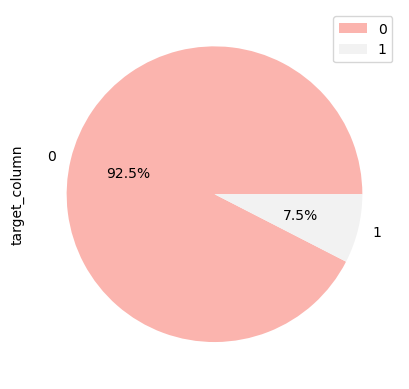

In [37]:
y.groupby(target_column[0]).size().plot(kind='pie',
                                          y = "target_column",
                                          label = "target_column",
                                          autopct='%1.1f%%',
                                          legend=True,
                                          colormap='Pastel1')

The value of current outcome is imbalance and as I have only 47,116 records -> not much for downsampling -> I upweighting instead

In [38]:
X.head(5)

,AGE_GROUP_range,DT_TO_CREATE_ACC,DT_TO_EKYC,DT_TO_FT,Digital Direct Sale,Ecosystem,First_Transaction_Range,Is_foreign,Partnership,RB,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,TRANS_CNT,Telesale
0,1,2,224,0,0,0,4,0,0,1,0.66,0.24,0.38,0.29,1.0,0
1,3,1,5,3,0,0,4,0,1,0,0.97,0.94,0.94,0.86,1.0,0
2,2,14,3,12,1,0,4,0,0,0,0.94,0.87,0.90,0.88,1.0,0
3,3,4,7,5,0,0,3,0,0,0,1.00,0.93,0.91,0.91,1.0,1
4,4,77,29,30,0,1,4,0,0,0,0.91,0.87,0.96,0.97,1.0,0


In [39]:
y.head(5)

,Is_fraud
0,1
1,0
2,1
3,0
4,0


#### **Upsampling with SMOTE**

In [40]:
su = SMOTE(random_state=42)
X_su, y_su = su.fit_resample(X, y)

<Axes: ylabel='target_column'>

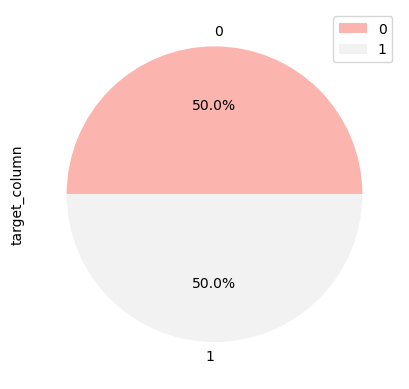

In [41]:
y_su.groupby(target_column[0]).size().plot(kind='pie',
                                          y = "target_column",
                                          label = "target_column",
                                          autopct='%1.1f%%',
                                          legend=True,
                                          colormap='Pastel1')

### Outlier Handler

In [42]:
def boxplt(df,features):
    # get name of columns
    int_vars = features

    # create a figure with subplots
    num_cols=len(int_vars)
    num_rows = (num_cols+2)//4  

    fig, axs = plt.subplots(nrows=num_rows,ncols=4,figsize=(8,3*num_rows))
    axs=axs.flatten()

    # create a countplot for each feature
    for i, var in enumerate(int_vars):
        if i< num_cols:
            sns.boxplot(data=df,y=var, ax=axs[i])
            axs[i].set_title(var)

    # adjust spacing between subplots
    fig.tight_layout()

    # remove any extra empty subplots if needed
    if num_cols < len (axs):
        for i in range(num_cols,len(axs)):
            fig.delaxes(axs[i])

    # show plot
    plt.show()

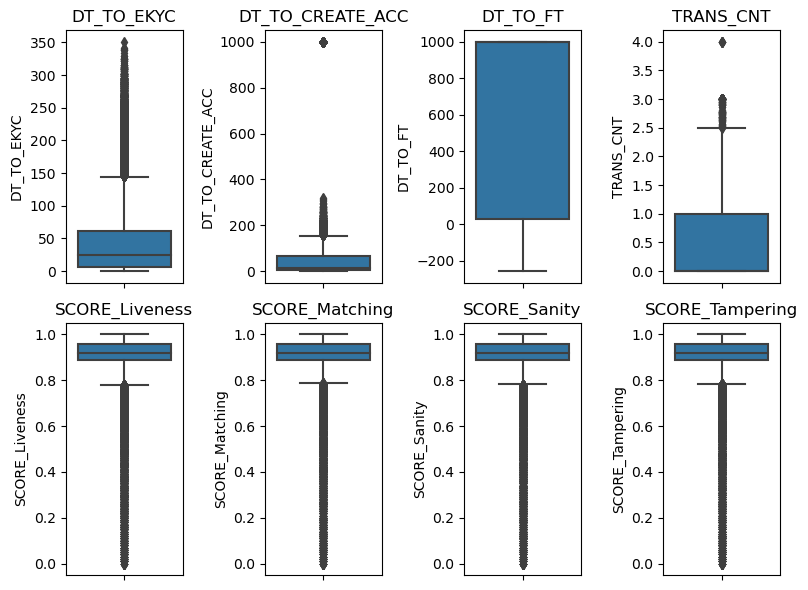

In [43]:
boxplt(X_su,num_columns)

In [44]:
X_su.head(5)

,AGE_GROUP_range,DT_TO_CREATE_ACC,DT_TO_EKYC,DT_TO_FT,Digital Direct Sale,Ecosystem,First_Transaction_Range,Is_foreign,Partnership,RB,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,TRANS_CNT,Telesale
0,1,2,224,0,0,0,4,0,0,1,0.66,0.24,0.38,0.29,1.0,0
1,3,1,5,3,0,0,4,0,1,0,0.97,0.94,0.94,0.86,1.0,0
2,2,14,3,12,1,0,4,0,0,0,0.94,0.87,0.90,0.88,1.0,0
3,3,4,7,5,0,0,3,0,0,0,1.00,0.93,0.91,0.91,1.0,1
4,4,77,29,30,0,1,4,0,0,0,0.91,0.87,0.96,0.97,1.0,0


In [45]:
def outlier_handler(df,col):
    # IQR
    # Calculate the upper and lower limits
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df


In [46]:
for i in num_columns:
    X_su = outlier_handler(X_su,i)

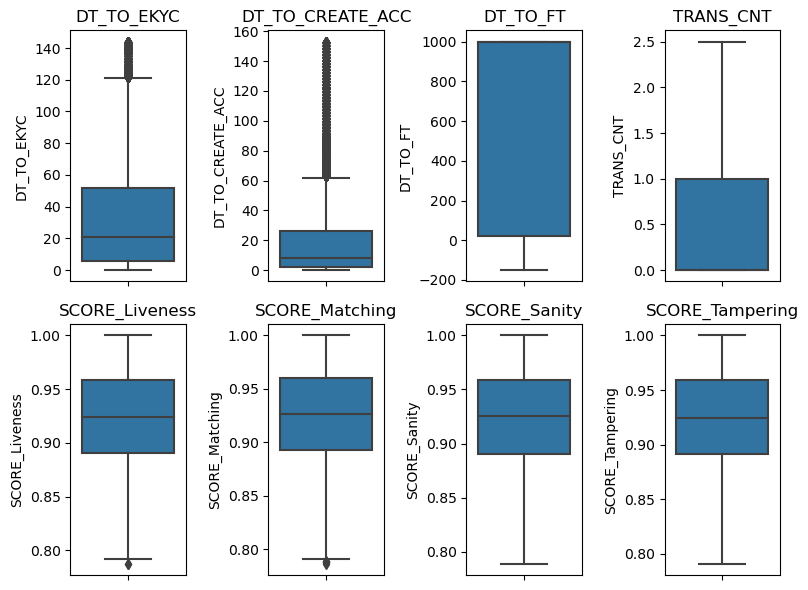

In [47]:
boxplt(X_su,num_columns)

In [48]:
# Print the new shape of the DataFrame
print("New Shape: ", X_su.shape)

New Shape:  (62696, 16)


In [49]:
X_su.shape

(62696, 16)

In [50]:
y_su.shape

(87126, 1)

In [51]:
X_su.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            87111, 87112, 87113, 87114, 87115, 87116, 87117, 87118, 87122,
            87124],
           dtype='int64', length=62696)

In [52]:
# Restruct target
new_df = X_su.copy()
new_df['target'] = y_su.loc[X_su.index]

In [53]:
new_cat_columns = X_su.columns.difference(num_columns)

In [54]:
new_cat_columns

Index(['AGE_GROUP_range', 'Digital Direct Sale', 'Ecosystem',
       'First_Transaction_Range', 'Is_foreign', 'Partnership', 'RB',
       'Telesale'],
      dtype='object')

In [55]:
for i in new_cat_columns:
  if i != 'CURRENT_OUTCOME':
    print('--------- Value report on column:',i,'-----------')
    report = X_su[i].value_counts(normalize=True,ascending=False).round(2)
    print(report)

--------- Value report on column: AGE_GROUP_range -----------
1    0.28
2    0.27
3    0.22
0    0.17
4    0.06
Name: AGE_GROUP_range, dtype: float64
--------- Value report on column: Digital Direct Sale -----------
0    0.87
1    0.13
Name: Digital Direct Sale, dtype: float64
--------- Value report on column: Ecosystem -----------
0    0.87
1    0.13
Name: Ecosystem, dtype: float64
--------- Value report on column: First_Transaction_Range -----------
0    0.63
4    0.23
3    0.13
2    0.01
1    0.00
Name: First_Transaction_Range, dtype: float64
--------- Value report on column: Is_foreign -----------
0    0.99
1    0.01
Name: Is_foreign, dtype: float64
--------- Value report on column: Partnership -----------
0    0.88
1    0.12
Name: Partnership, dtype: float64
--------- Value report on column: RB -----------
0    0.87
1    0.13
Name: RB, dtype: float64
--------- Value report on column: Telesale -----------
0    0.87
1    0.13
Name: Telesale, dtype: float64


### **Data Selection**

In [56]:
X_su.corr().round(2)

,AGE_GROUP_range,DT_TO_CREATE_ACC,DT_TO_EKYC,DT_TO_FT,Digital Direct Sale,Ecosystem,First_Transaction_Range,Is_foreign,Partnership,RB,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,TRANS_CNT,Telesale
AGE_GROUP_range,1.00,-0.02,-0.01,0.01,0.03,0.03,-0.01,0.01,0.03,0.04,-0.00,0.00,-0.03,-0.01,-0.01,0.04
DT_TO_CREATE_ACC,-0.02,1.00,0.19,-0.04,-0.02,-0.02,0.04,0.01,-0.03,-0.02,0.01,-0.01,-0.00,0.01,0.04,-0.02
DT_TO_EKYC,-0.01,0.19,1.00,-0.01,-0.03,-0.03,0.01,0.01,-0.00,-0.04,0.01,0.02,-0.01,0.00,0.01,-0.04
DT_TO_FT,0.01,-0.04,-0.01,1.00,0.02,0.03,-0.98,-0.00,0.01,0.02,0.00,0.01,0.01,-0.01,-0.95,0.02
Digital Direct Sale,0.03,-0.02,-0.03,0.02,1.00,-0.15,-0.02,0.02,-0.14,-0.14,-0.01,-0.00,0.00,0.01,-0.02,-0.14
Ecosystem,0.03,-0.02,-0.03,0.03,-0.15,1.00,-0.03,0.02,-0.15,-0.15,0.01,-0.01,0.01,-0.02,-0.03,-0.15
First_Transaction_Range,-0.01,0.04,0.01,-0.98,-0.02,-0.03,1.00,0.00,-0.01,-0.02,-0.00,-0.01,-0.01,0.01,0.93,-0.01
Is_foreign,0.01,0.01,0.01,-0.00,0.02,0.02,0.00,1.00,0.02,0.03,0.00,0.00,-0.00,-0.00,0.00,0.01
Partnership,0.03,-0.03,-0.00,0.01,-0.14,-0.15,-0.01,0.02,1.00,-0.14,-0.00,0.00,0.00,-0.00,-0.01,-0.14
RB,0.04,-0.02,-0.04,0.02,-0.14,-0.15,-0.02,0.03,-0.14,1.00,-0.00,-0.02,-0.01,0.00,-0.02,-0.14


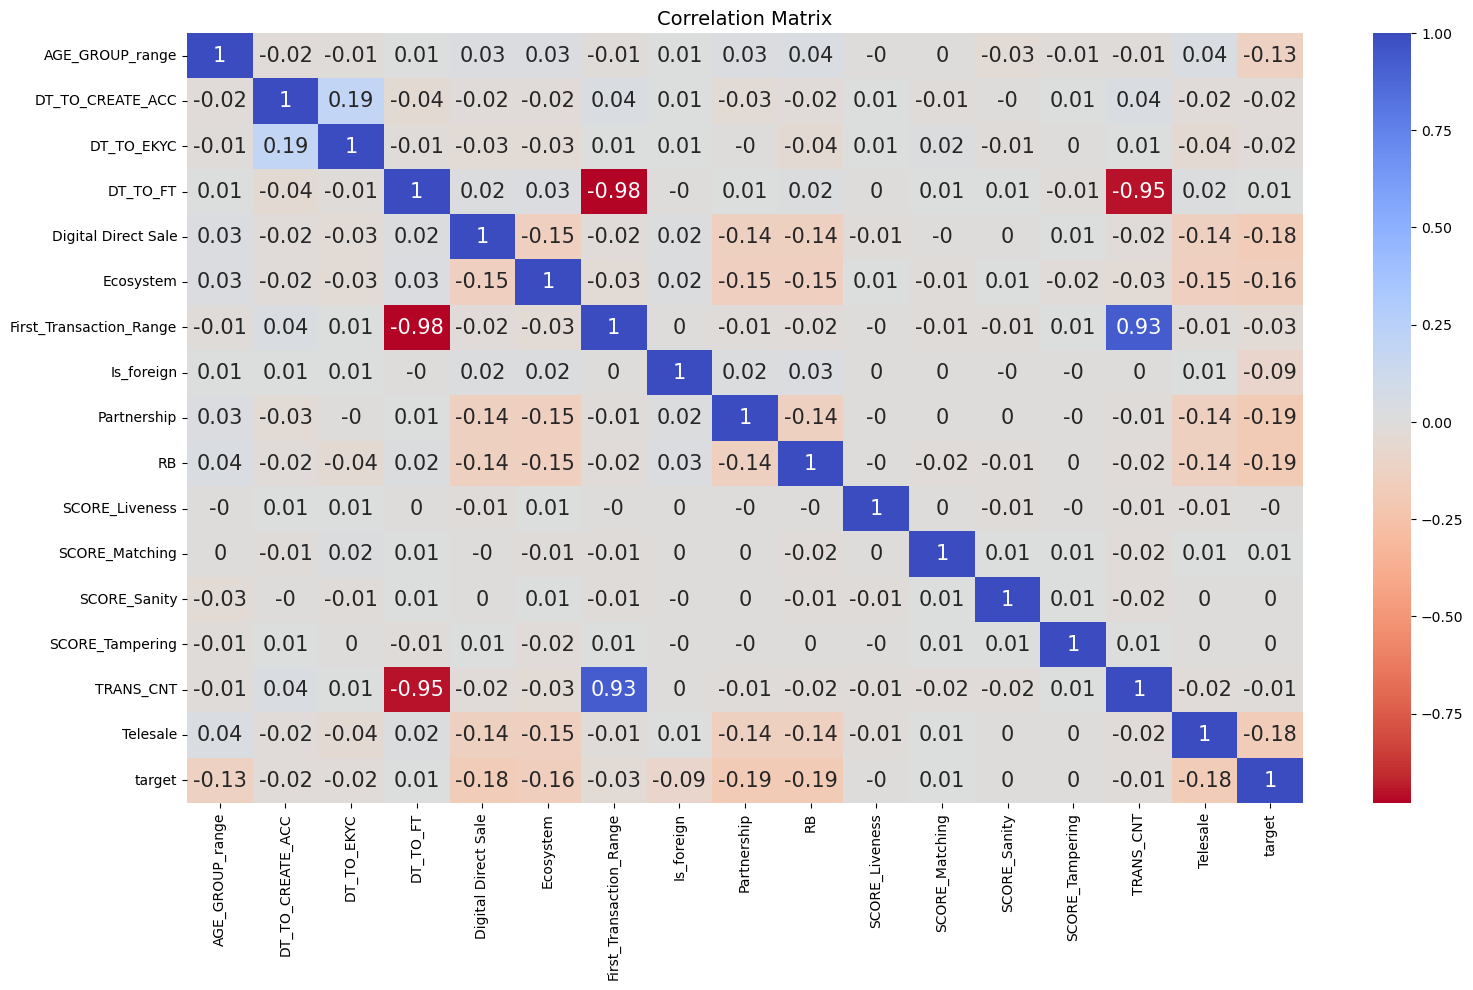

In [57]:
f = plt.subplots(figsize=(18,10))
corr_mat = new_df.corr().round(2)
sns.heatmap(corr_mat, cmap='coolwarm_r', annot_kws={'size':15},annot=True)
plt.title('Correlation Matrix', fontsize=14)
plt.show()


In [58]:
abs(corr_mat['target']).quantile(0.5)

0.03

I only take the top 50% of correlation with target
-> I remove all the columns with abs correlation less than 0.03

In [59]:
corr_mat[abs(corr_mat['target'])<=0.03]

,AGE_GROUP_range,DT_TO_CREATE_ACC,DT_TO_EKYC,DT_TO_FT,Digital Direct Sale,Ecosystem,First_Transaction_Range,Is_foreign,Partnership,RB,SCORE_Liveness,SCORE_Matching,SCORE_Sanity,SCORE_Tampering,TRANS_CNT,Telesale,target
DT_TO_CREATE_ACC,-0.02,1.00,0.19,-0.04,-0.02,-0.02,0.04,0.01,-0.03,-0.02,0.01,-0.01,-0.00,0.01,0.04,-0.02,-0.02
DT_TO_EKYC,-0.01,0.19,1.00,-0.01,-0.03,-0.03,0.01,0.01,-0.00,-0.04,0.01,0.02,-0.01,0.00,0.01,-0.04,-0.02
DT_TO_FT,0.01,-0.04,-0.01,1.00,0.02,0.03,-0.98,-0.00,0.01,0.02,0.00,0.01,0.01,-0.01,-0.95,0.02,0.01
First_Transaction_Range,-0.01,0.04,0.01,-0.98,-0.02,-0.03,1.00,0.00,-0.01,-0.02,-0.00,-0.01,-0.01,0.01,0.93,-0.01,-0.03
SCORE_Liveness,-0.00,0.01,0.01,0.00,-0.01,0.01,-0.00,0.00,-0.00,-0.00,1.00,0.00,-0.01,-0.00,-0.01,-0.01,-0.00
SCORE_Matching,0.00,-0.01,0.02,0.01,-0.00,-0.01,-0.01,0.00,0.00,-0.02,0.00,1.00,0.01,0.01,-0.02,0.01,0.01
SCORE_Sanity,-0.03,-0.00,-0.01,0.01,0.00,0.01,-0.01,-0.00,0.00,-0.01,-0.01,0.01,1.00,0.01,-0.02,0.00,0.00
SCORE_Tampering,-0.01,0.01,0.00,-0.01,0.01,-0.02,0.01,-0.00,-0.00,0.00,-0.00,0.01,0.01,1.00,0.01,0.00,0.00
TRANS_CNT,-0.01,0.04,0.01,-0.95,-0.02,-0.03,0.93,0.00,-0.01,-0.02,-0.01,-0.02,-0.02,0.01,1.00,-0.02,-0.01


In [60]:
#'DT_TO_CREATE_ACC','DT_TO_EKYC','DT_TO_FT','First_Transaction_Range','SCORE_Liveness','SCORE_Matching','SCORE_Sanity','SCORE_Tampering','TRANS_CNT'

In [61]:
train_df = new_df.drop(columns=corr_mat[abs(corr_mat['target'])<=0.03].index)

In [62]:
# Backup data to use later
bk_train_df = new_df.drop(columns=corr_mat[abs(corr_mat['target'])<=0.03].index)

In [63]:
train_df

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
1,3,0,0,0,1,0,0,0
2,2,1,0,0,0,0,0,1
3,3,0,0,0,0,0,1,0
4,4,0,1,0,0,0,0,0
5,2,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...
87116,2,0,0,0,0,0,1,1
87117,2,0,0,0,0,0,0,1
87118,1,0,0,0,1,0,0,1
87122,0,0,0,0,0,0,0,1


In [64]:
bk_train_df

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
1,3,0,0,0,1,0,0,0
2,2,1,0,0,0,0,0,1
3,3,0,0,0,0,0,1,0
4,4,0,1,0,0,0,0,0
5,2,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...
87116,2,0,0,0,0,0,1,1
87117,2,0,0,0,0,0,0,1
87118,1,0,0,0,1,0,0,1
87122,0,0,0,0,0,0,0,1


<Axes: >

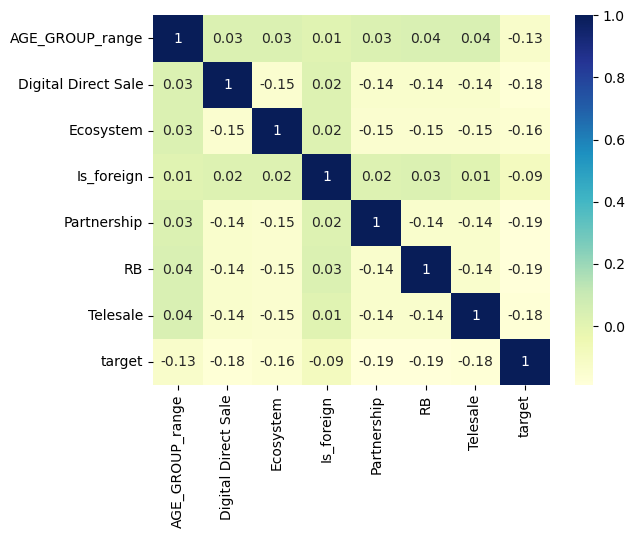

In [65]:
sns.heatmap(round(train_df.corr(),2), cmap="YlGnBu", annot=True)

In [66]:
bk_train_df.shape

(62696, 8)

In [67]:
train_df.shape

(62696, 8)

## Hold-out set

In [68]:
hold_out_df = train_df.sample(12500)

In [69]:
hold_out_df.shape

(12500, 8)

In [70]:
removed_df = train_df.index.isin(hold_out_df.index)

In [71]:
train_df = train_df[~removed_df]

In [72]:
train_df.shape

(50196, 8)

# DATA MODEL

In [73]:
train_df.shape

(50196, 8)

In [74]:
train_df.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
2,2,1,0,0,0,0,0,1
3,3,0,0,0,0,0,1,0
4,4,0,1,0,0,0,0,0
6,1,0,1,0,0,0,0,0
8,2,0,0,0,0,1,0,0


In [75]:
X = train_df.iloc[:,:7]
y = train_df.iloc[:,-1]

In [76]:
X.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale
2,2,1,0,0,0,0,0
3,3,0,0,0,0,0,1
4,4,0,1,0,0,0,0
6,1,0,1,0,0,0,0
8,2,0,0,0,0,1,0


In [77]:
y.head(5)

2    1
3    0
4    0
6    0
8    0
Name: target, dtype: int64

### Feature Scaler

In [78]:
scale = StandardScaler()

scaled_X = scale.fit_transform(X)

print(scaled_X)

[[ 0.23279206  2.62676713 -0.39064844 ... -0.37487738 -0.3780161
  -0.37811936]
 [ 1.08747537 -0.3806961  -0.39064844 ... -0.37487738 -0.3780161
   2.64466758]
 [ 1.94215867 -0.3806961   2.55984643 ... -0.37487738 -0.3780161
  -0.37811936]
 ...
 [-0.62189125 -0.3806961  -0.39064844 ...  2.66753893 -0.3780161
  -0.37811936]
 [-1.47657456 -0.3806961  -0.39064844 ... -0.37487738 -0.3780161
  -0.37811936]
 [-0.62189125 -0.3806961  -0.39064844 ...  2.66753893 -0.3780161
  -0.37811936]]


In [79]:
X_scaled = pd.DataFrame(scaled_X)
X_scaled.columns = X.columns

In [80]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=100)


In [81]:
X_train.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale
18543,0.232792,-0.380696,-0.390648,-0.105544,2.667539,-0.378016,-0.378119
8364,-0.621891,-0.380696,2.559846,-0.105544,-0.374877,-0.378016,-0.378119
1959,1.087475,2.626767,-0.390648,-0.105544,-0.374877,-0.378016,-0.378119
8872,-1.476575,-0.380696,-0.390648,-0.105544,-0.374877,-0.378016,2.644668
25551,1.087475,-0.380696,2.559846,-0.105544,-0.374877,-0.378016,-0.378119


In [82]:
y.head(5)

2    1
3    0
4    0
6    0
8    0
Name: target, dtype: int64

In [83]:
X_train.shape

(37647, 7)

In [84]:
y_train.shape

(37647,)

## Model comprehension

In [85]:
# Prepare the configuration to run the test
results=[]
names=[]

In [86]:
# Prepare an array with all the algorithms
models = []
models.append(('LR',LogisticRegression()))
models.append(('CARD',DecisionTreeClassifier()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('NB',GaussianNB()))
models.append(('RFC',RandomForestClassifier()))

In [87]:
#Evaluate each model in turn
for name,model in models:
    kfold=model_selection.KFold(n_splits=10)
    cv_results=model_selection.cross_val_score(model,X_train,y_train,cv=kfold,scoring='recall')
    results.append(cv_results)
    names.append(name)
    msg="%s:%f(%f)"%(name,cv_results.mean(),cv_results.std())
    print(msg)

LR:0.611670(0.004871)
CARD:0.611670(0.004871)
KNN:0.715497(0.012873)
LDA:0.611670(0.004871)
NB:0.724881(0.018917)
RFC:0.611670(0.004871)


## Model Evaluation

### **Boxplot algorithm comparison**

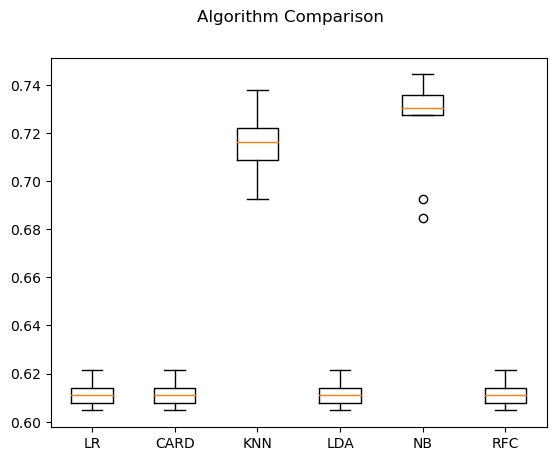

In [88]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

=> NB: Good Recall

### **ROC CURVE FOR COMPARISON**

In [89]:
# Logistic Regression

lr = LogisticRegression()
lr.fit(X_scaled,y)
y_score_lr = cross_val_predict(lr, X_scaled, y, method='decision_function',cv=10)
fpr, tpr, threshold = roc_curve(y,y_score_lr)

# Decision Tree

card = DecisionTreeClassifier()
card.fit(X_scaled,y)
y_score_card = cross_val_predict(card, X_scaled, y, method='predict_proba',cv=10)
fpr_card, tpr_card, threshold_card = roc_curve(y, y_score_card[:, 1])

# K Neighbor Classifier

knc = KNeighborsClassifier()
knc.fit(X_scaled,y)
knc_results = cross_val_score(knc,X_scaled,y,scoring='accuracy')
y_score_knn = cross_val_predict(knc,X_scaled,y,method='predict_proba',cv=10)
fpr_knn, tpr_knn, threshold_knn = roc_curve(y,y_score_knn[:,1])

# LDA

lda = LinearDiscriminantAnalysis()
lda.fit(X_scaled,y)
lda_results = cross_val_score(lda,X_scaled,y,scoring='accuracy')
y_score_lda = cross_val_predict(lda,X_scaled,y,method='predict_proba',cv=10)
fpr_lda, tpr_lda, threshold_lda = roc_curve(y,y_score_lda[:,1])

# GaussianNB

gnbc = GaussianNB()
gnbc.fit(X_scaled,y)
gnbc_results = cross_val_score(gnbc,X_scaled,y,scoring='accuracy')
y_score_gnb = cross_val_predict(gnbc,X_scaled,y,method='predict_proba',cv=10)
fpr_gnb, tpr_gnb, threshold_gnb = roc_curve(y,y_score_gnb[:,1])

# Random Forest

rfc = RandomForestClassifier()
rfc.fit(X_scaled,y)
rfc_results = cross_val_score(rfc,X_scaled,y,scoring='accuracy')
y_score_rfc = cross_val_predict(rfc,X_scaled,y,method='predict_proba',cv=10)
fpr_rfc, tpr_rfc, threshold_rfc = roc_curve(y,y_score_rfc[:,1])



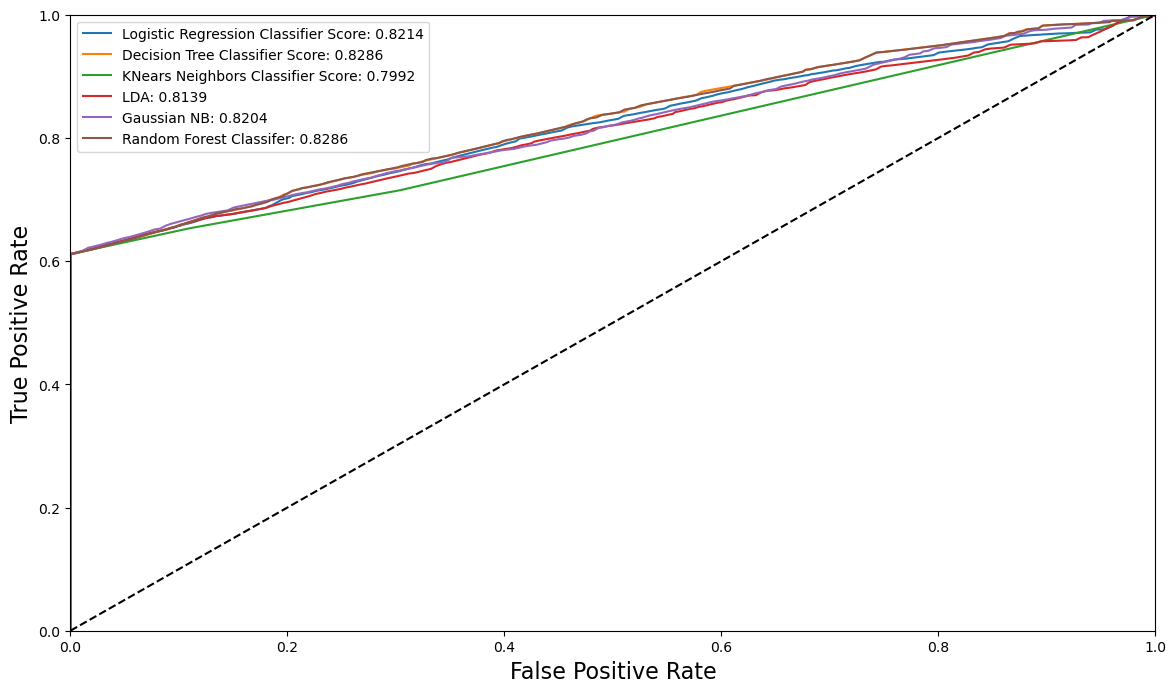

<function matplotlib.pyplot.show(close=None, block=None)>

In [90]:
# ROC Curve for the models above
plt.figure(figsize=(14,8))
plt.plot(fpr,tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y, y_score_lr)))
plt.plot(fpr_card, tpr_card,label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y, y_score_card[:, 1])))
plt.plot(fpr_knn, tpr_knn,label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y, y_score_knn[:, 1])))
plt.plot(fpr_lda, tpr_lda,label='LDA: {:.4f}'.format(roc_auc_score(y, y_score_lda[:, 1])))
plt.plot(fpr_gnb, tpr_gnb,label='Gaussian NB: {:.4f}'.format(roc_auc_score(y, y_score_gnb[:, 1])))
plt.plot(fpr_rfc, tpr_rfc,label='Random Forest Classifer: {:.4f}'.format(roc_auc_score(y, y_score_rfc[:, 1])))
plt.legend()
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()
plt.show

=> RFC: Good Precision

**Voting Ensemble Method**

I use soft voting ensemble method to predict the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers.

I fit the model to the third dataset, smallest and representative

In [91]:
Vote_Ensemble = VotingClassifier(estimators=[('nb', gnbc), ('rf', rfc)], voting='soft')

In [92]:
Vote_Ensemble.fit(X_scaled,y)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [93]:
Vote_Ensemble

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [94]:
# Save model
import pickle
# save the model to disk
filename = r'D:\An\DataFeild\My Project\Customer Onboarding Project\Full\Case 4 - Fraud Predictive Model\finalized_model.pkl'
pickle.dump(Vote_Ensemble, open(filename, 'wb'))

# DATA EVALUATION & THRESHOLD JUSTIFICATION


In [95]:
loaded_model = pickle.load(open(filename, 'rb'))

**Loading hold out set**

In [96]:
hold_out_df.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
4130,3,0,0,0,0,1,0,0
67050,2,0,0,0,0,0,0,1
53112,1,1,0,0,0,0,0,1
39671,0,0,0,0,0,1,0,0
8972,3,0,1,0,0,0,0,0


In [97]:
X_holdout = hold_out_df.iloc[:,0:7]
y_holdout = hold_out_df.iloc[:,-1]

In [98]:
scaled_X_test = scale.fit_transform(X_holdout)

In [99]:
X_test_scaled = pd.DataFrame(scaled_X_test)
X_test_scaled.columns = X_scaled.columns

In [100]:
X_test_scaled.head(5)


,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale
0,1.090404,-0.382031,-0.383268,-0.105268,-0.377619,2.627050,-0.380793
1,0.237940,-0.382031,-0.383268,-0.105268,-0.377619,-0.380655,-0.380793
2,-0.614525,2.617586,-0.383268,-0.105268,-0.377619,-0.380655,-0.380793
3,-1.466989,-0.382031,-0.383268,-0.105268,-0.377619,2.627050,-0.380793
4,1.090404,-0.382031,2.609142,-0.105268,-0.377619,-0.380655,-0.380793


In [101]:
loaded_model.fit(X_test_scaled,y_holdout)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [102]:
loaded_model.predict(X_test_scaled)

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [103]:
X_test_scaled.shape

(12500, 7)

In [104]:
y_holdout.shape

(12500,)

### Confusion Matrix

In [105]:
# Make predictions on the test set
y_pred = loaded_model.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_holdout, y_pred)
classification_report_str = classification_report(y_holdout, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_str)

Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.85      0.73      4939
           1       0.87      0.68      0.76      7561

    accuracy                           0.75     12500
   macro avg       0.75      0.76      0.75     12500
weighted avg       0.78      0.75      0.75     12500



### Justify the threshold

In [106]:
import matplotlib.pyplot as plt

class_index = [1]
y_score = loaded_model.predict_proba(X_test_scaled)

In [107]:
loaded_model.predict_proba(X_test_scaled)

array([[0.63083975, 0.36916025],
       [0.00912059, 0.99087941],
       [0.50596974, 0.49403026],
       ...,
       [0.54200585, 0.45799415],
       [0.01311357, 0.98688643],
       [0.76238561, 0.23761439]])

In [108]:
test = X_test_scaled.copy()
test['prob'] = loaded_model.predict_proba(X_test_scaled)[:,1]
test['output'] = loaded_model.predict(X_test_scaled)

In [109]:
fail = test.loc[test['output']==0,'prob']
success = test.loc[test['output']==1,'prob']

Text(0.5, 1.0, 'Box Plot Comparison')

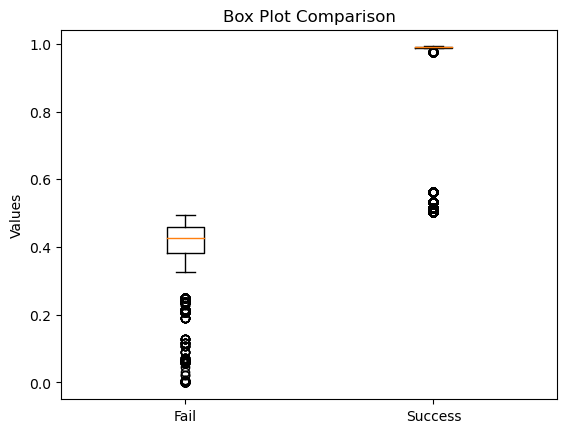

In [110]:
# Create a figure and axis objects
fig, ax = plt.subplots()

# Create the box plots
ax.boxplot([fail, success])

# Set labels and title
ax.set_xticklabels(['Fail', 'Success'])
ax.set_ylabel('Values')
ax.set_title('Box Plot Comparison')

In [111]:
success.describe()

count    5884.000000
mean        0.887808
std         0.192375
min         0.502853
25%         0.986886
50%         0.990879
75%         0.992042
max         0.992283
Name: prob, dtype: float64

### Optimize threshold

In [112]:
y_score_positive = y_score[:, 1]

In [113]:
print("y_test shape:", y_test.shape)
print("y_score_positive shape:", y_score_positive.shape)

y_test shape: (12549,)
y_score_positive shape: (12500,)


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


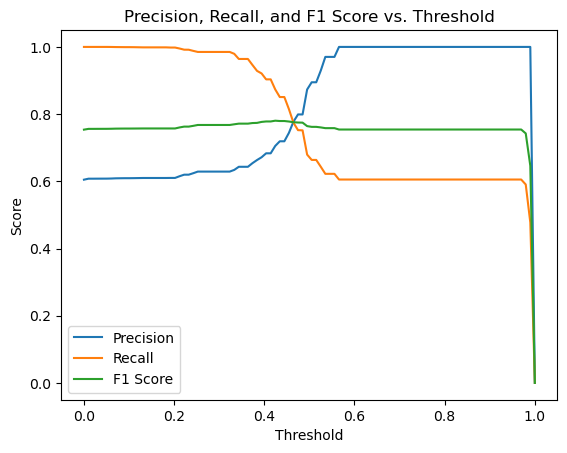

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_test contains the true labels and y_score_positive contains the predicted probabilities for the positive class

# Define a range of thresholds
thresholds = np.linspace(0, 1, num=100)

# Calculate precision, recall, and F1 score for each threshold
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred = (y_score_positive >= threshold).astype(int)
    precisions.append(precision_score(y_holdout, y_pred))
    recalls.append(recall_score(y_holdout, y_pred))
    f1_scores.append(f1_score(y_holdout, y_pred))

# Plot precision, recall, and F1 score against thresholds
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1 Score')

# Set labels and title
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Threshold')
plt.legend()

# Show the plot
plt.show()

**Try raising the threshold up to 0.45**

In [120]:
y_pred_threshold = np.array([1 if i >= 0.46 else 0 for i in test['prob']])

In [121]:
classification_report_str_46 = classification_report(y_holdout, y_pred_threshold)
accuracy_46 = accuracy_score(y_holdout, y_pred_threshold)

In [122]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [123]:
# Threshold = 0.5
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report_str)

Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.85      0.73      4939
           1       0.87      0.68      0.76      7561

    accuracy                           0.75     12500
   macro avg       0.75      0.76      0.75     12500
weighted avg       0.78      0.75      0.75     12500



In [124]:
# Threshold = 0.46
print(f"Accuracy: {accuracy_46:.2f}")
print("Classification Report:")
print(classification_report_str_46)

Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66      4939
           1       0.78      0.77      0.78      7561

    accuracy                           0.73     12500
   macro avg       0.72      0.72      0.72     12500
weighted avg       0.73      0.73      0.73     12500



=> The accuracy drop a tiny bit (2%). However, the model become stricter in classifying a customer as normal -> lower threshold to catch fraud -> the recall for 1 and precision for 0 raise =>  => More accurate in catch 'sophisticated fraud' => In return, we lose the opportunity to save cost as the precision/right level of prediction drop

# MODEL OUTPUT

In [125]:
bk_train_df.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,target
1,3,0,0,0,1,0,0,0
2,2,1,0,0,0,0,0,1
3,3,0,0,0,0,0,1,0
4,4,0,1,0,0,0,0,0
5,2,0,0,1,0,1,0,0


In [126]:
X_bk = bk_train_df.iloc[:,0:7]
y_bk = bk_train_df.iloc[:,-1]

In [127]:
scaled_X_bk = scale.fit_transform(X_bk)

In [128]:
loaded_model.fit(scaled_X_bk,y_bk)

VotingClassifier(estimators=[('nb', GaussianNB()),
                             ('rf', RandomForestClassifier())],
                 voting='soft')

In [129]:
X_bk_scaled = pd.DataFrame(scaled_X_bk)
X_bk_scaled.columns = X_scaled.columns

In [130]:
X_bk_scaled.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale
0,1.088057,-0.380962,-0.389182,-0.105489,2.663650,-0.378543,-0.378653
1,0.233820,2.624930,-0.389182,-0.105489,-0.375425,-0.378543,-0.378653
2,1.088057,-0.380962,-0.389182,-0.105489,-0.375425,-0.378543,2.640939
3,1.942294,-0.380962,2.569490,-0.105489,-0.375425,-0.378543,-0.378653
4,0.233820,-0.380962,-0.389182,9.479650,-0.375425,2.641708,-0.378653


In [131]:
loaded_model.predict(X_bk_scaled)

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [132]:
df_fin = X_bk_scaled.copy()

In [133]:
df_fin['y_actual'] = y_bk
df_fin['prob'] = loaded_model.predict_proba(X_bk_scaled)[:,1]

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [134]:
df_fin.head(5)

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,y_actual,prob
0,1.088057,-0.380962,-0.389182,-0.105489,2.663650,-0.378543,-0.378653,NaN,0.300139
1,0.233820,2.624930,-0.389182,-0.105489,-0.375425,-0.378543,-0.378653,0.0,0.393819
2,1.088057,-0.380962,-0.389182,-0.105489,-0.375425,-0.378543,2.640939,1.0,0.386000
3,1.942294,-0.380962,2.569490,-0.105489,-0.375425,-0.378543,-0.378653,0.0,0.326362
4,0.233820,-0.380962,-0.389182,9.479650,-0.375425,2.641708,-0.378653,0.0,0.134696


In [135]:
y_pred_threshold_fin = np.array([1 if i >= 0.45 else 0 for i in df_fin['prob']])

In [136]:
accuracy_fin = accuracy_score(y_bk, y_pred_threshold_fin)
print(f"Accuracy: {accuracy_fin:.2f}")
c_fin = classification_report(y_bk, y_pred_threshold_fin)
print(c_fin)

Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.66      0.67      0.66     24956
           1       0.78      0.77      0.77     37740

    accuracy                           0.73     62696
   macro avg       0.72      0.72      0.72     62696
weighted avg       0.73      0.73      0.73     62696



In [137]:
df_fin.to_csv(r'D:\An\DataFeild\My Project\Customer Onboarding Project\Full\Case 4 - Fraud Predictive Model\output.csv')

In [138]:
df_fin

,AGE_GROUP_range,Digital Direct Sale,Ecosystem,Is_foreign,Partnership,RB,Telesale,y_actual,prob
0,1.088057,-0.380962,-0.389182,-0.105489,2.663650,-0.378543,-0.378653,NaN,0.300139
1,0.233820,2.624930,-0.389182,-0.105489,-0.375425,-0.378543,-0.378653,0.0,0.393819
2,1.088057,-0.380962,-0.389182,-0.105489,-0.375425,-0.378543,2.640939,1.0,0.386000
3,1.942294,-0.380962,2.569490,-0.105489,-0.375425,-0.378543,-0.378653,0.0,0.326362
4,0.233820,-0.380962,-0.389182,9.479650,-0.375425,2.641708,-0.378653,0.0,0.134696
...,...,...,...,...,...,...,...,...,...
62691,0.233820,-0.380962,-0.389182,-0.105489,-0.375425,-0.378543,2.640939,1.0,0.427668
62692,0.233820,-0.380962,-0.389182,-0.105489,-0.375425,-0.378543,-0.378653,1.0,0.990080
62693,-0.620417,-0.380962,-0.389182,-0.105489,2.663650,-0.378543,-0.378653,1.0,0.406541
62694,-1.474655,-0.380962,-0.389182,-0.105489,-0.375425,-0.378543,-0.378653,1.0,0.991744
